# Creating an DL Application that can classify 10 different animals using Pytorch

# Importing required packages and setting execution environment

In [1]:
import torch
from torch import optim
from torch.optim import lr_scheduler
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy.orm import mapper
import json
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

# from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import copy
import time
import os

In [2]:
from PIL import Image
from torch.autograd import Variable
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import models

In [3]:
import pandas as pd
from torchvision import datasets
from torch.utils.data.dataset import Dataset

If the size of our dataset is between 100 to 10,00,000, then we split it in the ratio 60:20:20. That is 60% data will go to the Training Set, 20% to the Dev Set and remaining to the Test Set.
If the size of the data set is greater than 1 million then we can split it in something like this 98:1:1 or 99:0.5:0.5

**Setting device for execution**

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(device)

cuda


# Load files and Datasets

In [5]:
!unzip '/content/drive/My Drive/Animal Classification/data.zip' 

Streaming output truncated to the last 5000 lines.
  inflating: data/val/ragno/OIP-4dK6_G8d_dvH716pOYixOgHaFi.jpeg  
  inflating: data/val/ragno/OIP-cLxP_pbfCmwknjagDaDxxgAAAA.jpeg  
  inflating: data/val/ragno/OIP-c7cAUfZxufWOXzx3CrRq4AHaEv.jpeg  
  inflating: data/val/ragno/OIP-qyii-nHUvgUXTkOpWPxIfwEsDJ.jpeg  
  inflating: data/val/ragno/OIP-ATMfwsi2hZE5EC6ZRnMzDwHaJp.jpeg  
  inflating: data/val/ragno/OIP-UB0mB8bK4rhLhu8ckbVa_QHaFP.jpeg  
  inflating: data/val/ragno/OIP-t_d0F3ECZF0jcQ2RJ4RK5QHaE6.jpeg  
  inflating: data/val/ragno/OIP-79I7SZGRi6fLiK9JDPKh4gHaE-.jpeg  
  inflating: data/val/ragno/OIP-qOa4UatUvreR5nYTjDWpfwHaF0.jpeg  
  inflating: data/val/ragno/OIP-cZQfUKoh-eMspJ6fRei3-wAAAA.jpeg  
  inflating: data/val/ragno/OIP-gcr890BFOWYVZYQa_LXSjAHaG-.jpeg  
  inflating: data/val/ragno/eb3cb70f28f0053ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5ecb5b1_640.jpg  
  inflating: data/val/ragno/OIP-biOWA00l_dbYitwHy1QaOwHaKu.jpeg  
  inflating: data/val/ragno/OIP-nz0PDC0FpuPj4CS2R478Dg

In [6]:
#!mv '/content/data' '/content/drive/My Drive/Animal Classification'

In [7]:
with open('/content/drive/My Drive/Animal Classification/classes.json', 'r') as f:
    class_names = json.load(f)

In [8]:
class_names = {value:key for key, value in class_names.items() }
print(class_names)

{'dog': 'cane', 'horse': 'cavallo', 'elephant': 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'sheep': 'pecora', 'spider': 'ragno', 'squirrel': 'scoiattolo'}


# Processing Data for the Model

In [9]:
#data_dir = '/content/drive/My Drive/Animal Classification/data'
data_dir = '/content/data'
batch_size = 32

In [10]:
#Applying data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:

# datasets.ImageFolder('/content/data/val',data_transforms[x])

In [12]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Another method for dataset creation

In [ ]:
train_csv = pd.read_csv('/content/drive/MyDrive/DL_Course/animal_class.csv') 

In [ ]:
csv_train = '/content/drive/MyDrive/DL_Course/animal_class.csv'

In [ ]:
csv_train = pd.read_csv('/content/drive/MyDrive/DL_Course/animal_class.csv')

In [ ]:
class2idx = {}
idxt2class = {}
categ = sorted(csv_train['class'].unique())
for i, cat in enumerate(categ):
          print(f"i : {i}, cat: {cat}")
          class2idx[cat] = i
          idxt2class[i] = cat 

i : 0, cat: bird
i : 1, cat: cat
i : 2, cat: dog


In [ ]:
print(class2idx)

{'bird': 0, 'cat': 1, 'dog': 2}


In [ ]:
class xyzDataset(Dataset):
   def __init__(self, dataset, csv, input, label, tfms):
        self.csv = pd.read_csv(csv)
        self.root_dir = dataset
        self.transform = tfms
        self.class2idx = {}
        self.idxt2class = {}
        self.categories = sorted(self.csv[label].unique())
        for i, cat in enumerate(self.categories):
          self.class2idx[cat] = i
          self.idxt2class[i] = cat 
        #print(self.class2idx)
   def __len__(self):
        return len(self.csv)

   def __getitem__(self, index):
        row = self.csv.iloc[index]
        #print(row)
        #print(row[0])
        #print(row[1])
        img_path = os.path.join(self.root_dir, row[0]  + '.jpg')
        print(img_path)
        image = Image.open(img_path)
        #print(class2idx[row[1]])
        y_label = torch.tensor(self.class2idx[row[1]])
        #print(y_label)

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [ ]:
'/content/data/x1a.jpg'

In [ ]:
train_data = xyzDataset(data_dir, csv_train, 'files', 'class', data_transforms)

# Representation of a Batch of Images

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

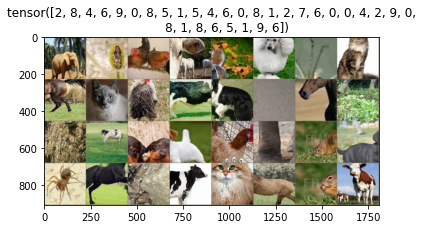

In [14]:
#see the images from dataloader
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#title = list(class_names[x] for x in classes)
#view a batch image
imshow(out, classes)

# Transfer Learning and Model Tuning

In [ ]:
model = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
for parms in model.parameters():
  parms.requires_grad=False

In [ ]:
#new Mode for 60-20-20 datsset split
classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512,64),
    nn.ReLU(),
    nn.Linear(64,10),
    nn.LogSoftmax()
)
model.fc = classifier

In [ ]:
for param in model.parameters():
    if param.requires_grad:  
        print(param.shape)

torch.Size([512, 2048])
torch.Size([512])
torch.Size([64, 512])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


# Training the Model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    #print("Start of train function")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Start of an epoch")
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                print("Train")
                model.train()  # Set model to training mode
            else:
                print("Validation")
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #print("Fetching inputs and true outputs from dataloader and phase: "+ phase)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #print("forward pass and phase: "+ phase)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#Training Hyperparameters

num_epochs = 20
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

# Optimisation of model parameters
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Start of an epoch
Epoch 0/19
----------
Train
train Loss: 0.3703 Acc: 0.8853
Validation
val Loss: 0.0948 Acc: 0.9725

Start of an epoch
Epoch 1/19
----------
Train
train Loss: 0.2601 Acc: 0.9150
Validation
val Loss: 0.0834 Acc: 0.9767

Start of an epoch
Epoch 2/19
----------
Train
train Loss: 0.2439 Acc: 0.9199
Validation
val Loss: 0.0827 Acc: 0.9767

Start of an epoch
Epoch 3/19
----------
Train
train Loss: 0.2333 Acc: 0.9222
Validation
val Loss: 0.0754 Acc: 0.9770

Start of an epoch
Epoch 4/19
----------
Train
train Loss: 0.2259 Acc: 0.9277
Validation
val Loss: 0.0887 Acc: 0.9744

Start of an epoch
Epoch 5/19
----------
Train
train Loss: 0.2215 Acc: 0.9286
Validation
val Loss: 0.0810 Acc: 0.9759

Start of an epoch
Epoch 6/19
----------
Train
train Loss: 0.2142 Acc: 0.9315
Validation
val Loss: 0.0790 Acc: 0.9790

Start of an epoch
Epoch 7/19
----------
Train
train Loss: 0.1829 Acc: 0.9389
Validation
val Loss: 0.0713 Acc: 0.9813

Start of an epoch
Epoch 8/19
----------
Train
train Loss

# Test

In [ ]:
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['test']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

    del images, labels, output  #Freeing GPU memory and cache for preventing VRAM overflow 
    torch.cuda.empty_cache()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))

In [ ]:
test(model_ft, dataloaders, device)

Testing Accuracy: 0.012
Testing Accuracy: 0.024
Testing Accuracy: 0.036
Testing Accuracy: 0.048
Testing Accuracy: 0.060
Testing Accuracy: 0.072
Testing Accuracy: 0.083
Testing Accuracy: 0.096
Testing Accuracy: 0.108
Testing Accuracy: 0.120
Testing Accuracy: 0.131
Testing Accuracy: 0.144
Testing Accuracy: 0.156
Testing Accuracy: 0.168
Testing Accuracy: 0.179
Testing Accuracy: 0.191
Testing Accuracy: 0.203
Testing Accuracy: 0.215
Testing Accuracy: 0.227
Testing Accuracy: 0.239
Testing Accuracy: 0.251
Testing Accuracy: 0.262
Testing Accuracy: 0.274
Testing Accuracy: 0.287
Testing Accuracy: 0.299
Testing Accuracy: 0.311
Testing Accuracy: 0.323
Testing Accuracy: 0.335
Testing Accuracy: 0.347
Testing Accuracy: 0.358
Testing Accuracy: 0.369
Testing Accuracy: 0.381
Testing Accuracy: 0.394
Testing Accuracy: 0.405
Testing Accuracy: 0.417
Testing Accuracy: 0.429
Testing Accuracy: 0.441
Testing Accuracy: 0.453
Testing Accuracy: 0.465
Testing Accuracy: 0.477
Testing Accuracy: 0.489
Testing Accuracy

# Saving Trained Model

In [ ]:
PATH = '/content/drive/My Drive/Animal Classification/Animal_classifier_80-10-10.pth'

num_epochs = 10
model.epochs = num_epochs
model_ft.category_index = image_datasets['train'].class_to_idx 
checkpoint = {
              'epoch': model_ft.epochs,
              'model_state_dict': model_ft.state_dict(),
             'optimizer_state_dict': optimizer_ft.state_dict(),
             'category_index' :  model_ft.category_index
              }
torch.save(checkpoint, PATH)

# Codes for Debugging

In [ ]:
category_index = image_datasets['train'].class_to_idx 

In [ ]:
print(category_index)

{'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}


In [ ]:
PATH = '/content/drive/My Drive/Animal Classification/checkpoint_test_002_model_ft.pth'

## Fetching images for testing

In [ ]:
#Get an Image for Inference
!wget https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSKC9-npJIvZ5l4yzuDDFWy0FmZ0XPaeQWwjg&usqp=CAU
!wget https://t1.ea.ltmcdn.com/en/images/7/4/6/why_does_my_dog_like_to_roll_around_in_the_grass_2647_600_square.jpg
!wget https://images.unsplash.com/photo-1570745526295-8223b49b3c53?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&w=1000&q=80
!wget https://www.sciencemag.org/sites/default/files/styles/article_main_large/public/cat_1280p.jpg?itok=l_j_qSUs

--2021-01-17 11:40:47--  https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSKC9-npJIvZ5l4yzuDDFWy0FmZ0XPaeQWwjg
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.143.113, 74.125.143.139, 74.125.143.102, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.143.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7711 (7.5K) [image/jpeg]
Saving to: ‘images?q=tbn:ANd9GcSKC9-npJIvZ5l4yzuDDFWy0FmZ0XPaeQWwjg’

images?q=tbn:ANd9Gc 100%[===================>]   7.53K  --.-KB/s    in 0s      

2021-01-17 11:40:47 (72.0 MB/s) - ‘images?q=tbn:ANd9GcSKC9-npJIvZ5l4yzuDDFWy0FmZ0XPaeQWwjg’ saved [7711/7711]

--2021-01-17 11:40:47--  https://t1.ea.ltmcdn.com/en/images/7/4/6/why_does_my_dog_like_to_roll_around_in_the_grass_2647_600_square.jpg
Resolving t1.ea.ltmcdn.com (t1.ea.ltmcdn.com)... 185.59.222.24, 185.59.222.18, 195.181.172.6, ...
Connecting to t1.ea.ltmcdn.com (t1.ea.ltmcdn.com)|185.59.222.24|:443... connected.

In [ ]:
!mv  '/content/images?q=tbn:ANd9GcSKC9-npJIvZ5l4yzuDDFWy0FmZ0XPaeQWwjg' test1.jpg
!mv  '/content/why_does_my_dog_like_to_roll_around_in_the_grass_2647_600_square.jpg' test2.jpg
!mv  '/content/photo-1570745526295-8223b49b3c53?ixlib=rb-1.2.1' test3.jpg
!mv  '/content/cat_1280p.jpg?itok=l_j_qSUs' test4.jpg

# Loading Saved Model

In [ ]:
torch.cuda.empty_cache() 

## OLD

In [ ]:
#Old
PATH = '/content/drive/My Drive/Animal Classification/Animal_classifier_80-10-10.pth'
def load_checkpoint(filepath):

  if str(device) == 'cuda:0':
    print("GPU")
    checkpoint = torch.load(filepath, map_location=str(device))
  elif str(device) == 'cpu':
    print('CPU')
    checkpoint = torch.load(filepath, map_location=str(device))

  model = models.resnet152()
  for parms in model.parameters():
    parms.requires_grad=False
  classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512,64),
    nn.ReLU(),
    nn.Linear(64,10),
    nn.LogSoftmax()
)
  model.fc = classifier

  model.load_state_dict(checkpoint['model_state_dict'])
  return model, checkpoint['category_index']

#loaded_model = load_checkpoint(PATH)
loaded_model, category_index = load_checkpoint(PATH)
classifications = { values : key for key,values in category_index.items()} #swapping key and values

## New

In [ ]:
#New
PATH = '/content/drive/My Drive/Animal Classification/Animal_classifier_80-10-10.pth'
def load_checkpoint(filepath):

  # if str(device) == 'cuda:0':
  #   print("GPU")
  #   checkpoint = torch.load(filepath)
  # elif str(device) == 'cpu':
  #   print('CPU')
  checkpoint = torch.load(filepath, map_location='cpu') #map_location = 'cpu'

  model = models.resnet152()
  for parms in model.parameters():
    parms.requires_grad=False
  classifier = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512,64),
    nn.ReLU(),
    nn.Linear(64,10),
    nn.LogSoftmax()
)
  model.fc = classifier

  model.load_state_dict(checkpoint['model_state_dict']) #model.load_state_dict(model_ft.state_dict())
  model = model.to('cpu')

  return model , checkpoint['category_index']

#loaded_model = load_checkpoint(PATH)
loaded_model, category_index = load_checkpoint(PATH)
classifications = { values : key for key,values in category_index.items()} #swapping key and values
# [dog:0, horse:1] => [0:dog, 1:horsde]

In [ ]:
#model_ft = train_model(loaded_model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=20)

# Loaded Model Inference

**Loading Classification Labels**

In [ ]:
names = list(class_names.keys())
print(names)
print(classifications)

In [ ]:
for values,elem in zip(classifications.keys(), names):
  classifications[values] = str(elem) 
print(classifications)

In [ ]:
print(classifications)

{0: 'cane', 1: 'cavallo', 2: 'elefante', 3: 'farfalla', 4: 'gallina', 5: 'gatto', 6: 'mucca', 7: 'pecora', 8: 'ragno', 9: 'scoiattolo'}


**Loading Images and Prediction**


In [ ]:
def preprocess_data(image):
  preprocess = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  image = preprocess(image)
  #print(image)
  image = torch.unsqueeze(image, 0) # Adding batch format for the image dimension [3,224,224] -> [1,3,224,224]
  # image = image.to(device)
  return image

**Finding Top-5 Predictions**

In [ ]:
def top_five_predections(prob):
  values, indeces = torch.topk(prob, 5) # Extraction of top 5 predicted categories values and their classes
  #print(values)
  #print(indeces)
  #Converting to numpy to plot
  np_values = values.squeeze().detach().cpu().numpy()
  #print(np_values)
  np_indeces = indeces.squeeze().cpu().numpy()
  #print(np_indeces)
  return np_values,np_indeces
  

**Predicting the image**

In [ ]:
def prediction(img):
  loaded_model.eval()
  img = preprocess_data(img)
  probability = loaded_model(img) #Passing processed image to the saved model
  values, indeces = top_five_predections(probability)
  return values, indeces

In [ ]:
def plot_predection(img, filename):  
  fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
  ax1.imshow(img)
  ax1.set_title(filename)
  ax1.axis('off')

  plt_values, plt_indeces = prediction(img)
  
  y_pos = np.arange(len(plt_indeces))
  ax2.barh(y_pos, np.exp(plt_values))
  ax2.set_yticks(y_pos)
  ax2.set_yticklabels([classifications[x] for x in plt_indeces])
  ax2.invert_yaxis()

In [ ]:
# Simplified
def class_predection(img):
  plt_values, plt_indeces = prediction(img)
  for x, val in zip(plt_indeces, plt_values):
    print(f"Class:{classifications[x]} Value:{np.exp(val)}")

Class:elefante Value:1.0
Class:pecora Value:2.429634626821553e-08
Class:cavallo Value:2.2964037782458036e-08
Class:mucca Value:1.0613133483161619e-08
Class:cane Value:1.3732704973179466e-09


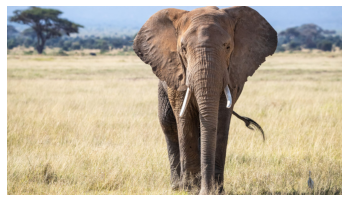

In [ ]:
image = Image.open(r'/content/front-view-of-a-bull-elephant-in-the-grasslands-of-amboseli-national-park--1219745751-08f3add138514ad091e82e29a11546cc.jpg')
plt.imshow(image)
plt.axis("off")
class_predection(image)

In [ ]:
  # plt_values, plt_indeces = prediction(image)
  # for i,val in plt_indeces,plt_values :
  #   classifications[i]
  #   plt_values[val]

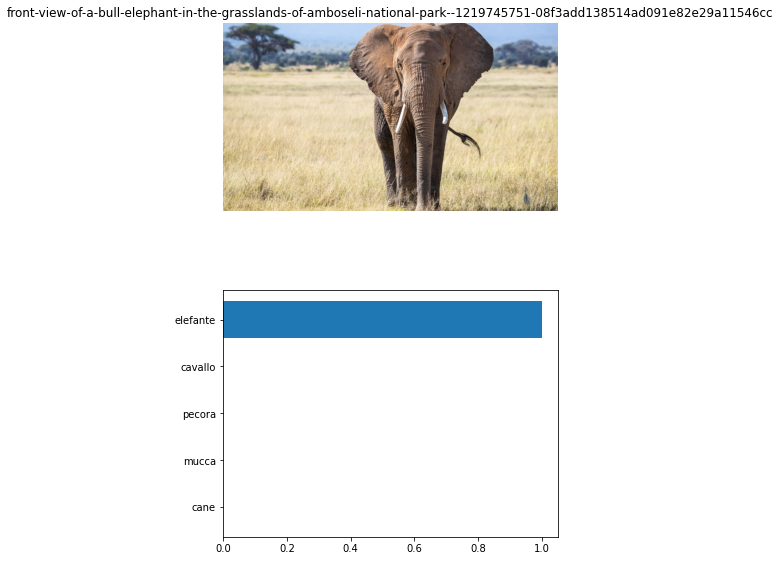

In [ ]:
image = Image.open('/content/front-view-of-a-bull-elephant-in-the-grasslands-of-amboseli-national-park--1219745751-08f3add138514ad091e82e29a11546cc.jpg')
filename = str(Path('/content/front-view-of-a-bull-elephant-in-the-grasslands-of-amboseli-national-park--1219745751-08f3add138514ad091e82e29a11546cc.jpg').stem) #Extracting Filename
plot_predection(image, filename)

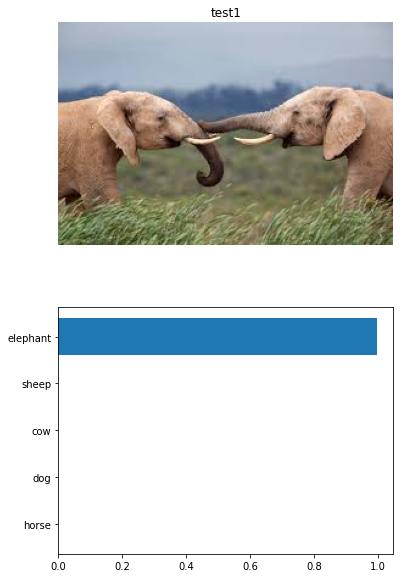

In [ ]:
image = Image.open('/content/test1.jpg')
filename = str(Path('/content/test1.jpg').stem) #Extracting Filename
plot_predection(image, filename)

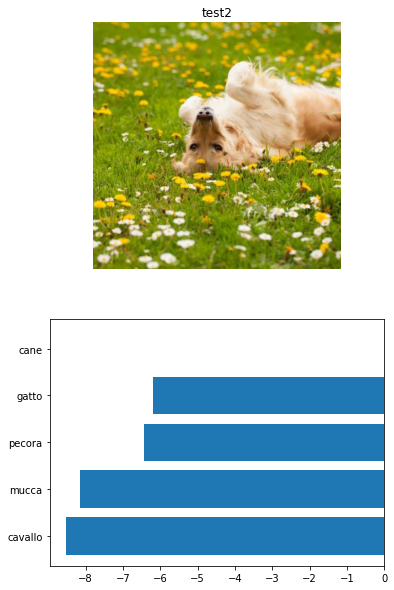

In [ ]:
image = Image.open('/content/test2.jpg')
filename = str(Path('/content/test2.jpg').stem) #Extracting Filename
plot_predection(image, filename)

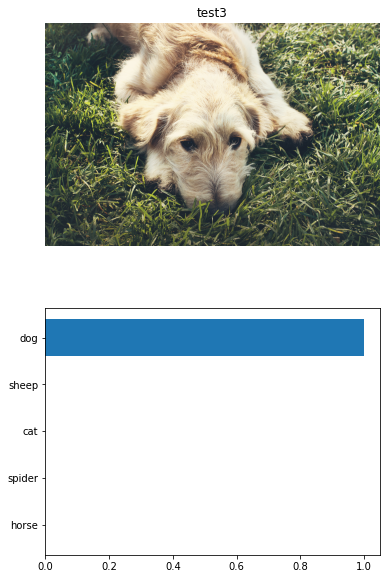

In [ ]:
image = Image.open('/content/test3.jpg')
filename = str(Path('/content/test3.jpg').stem) #Extracting Filename
plot_predection(image, filename)

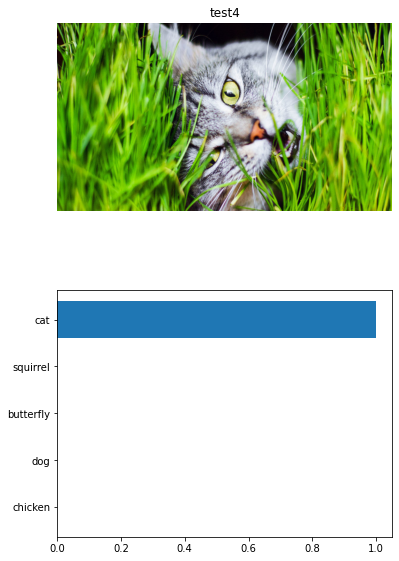

In [ ]:
image = Image.open('/content/test4.jpg')
filename = str(Path('/content/test4.jpg').stem) #Extracting Filename
plot_predection(image, filename)

#**Conclusion**


The Model is able to correcty predict images of animals in 10 categories with an accuracy of 98%. You may be able to improve the model with some fine tuning of hyperparameters .

